### Importing Necessary Packages

In [ ]:
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer


import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Importing Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
df

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


### Feature Engineering

In [ ]:
##Train data
df.shape

(20800, 5)

In [ ]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
df = df.dropna()
X=df.drop('label',axis=1)
y=df['label']
messages = X.copy()
messages.reset_index(inplace = True)
df.shape

(18285, 5)

#### Removing special characters, stop words and stemming of title column

In [ ]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)
corpus[3]

'civilian kill singl us airstrik identifi'

#### One Hot Representation

In [ ]:
### Vocabulary size
voc_size=5000
onehot_repr=[one_hot(words,voc_size) for words in corpus] 

#### Embedding Representation

In [ ]:
sent_length=20
embedded_docs = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2096 1613 3308]
 [   0    0    0 ... 2906 1494 3088]
 [   0    0    0 ...   99 1755 4915]
 ...
 [   0    0    0 ... 4757 1051  152]
 [   0    0    0 ... 1149 1547 2103]
 [   0    0    0 ... 4951 2921 3927]]


### Model Creation

#### Train Test Split

In [ ]:
X_final=np.array(embedded_docs)
y_final=np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

#### Model Training

In [ ]:
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


#### Model Fitting

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
192/192 [==============================] - 5s 14ms/step - loss: 0.3325 - accuracy: 0.8353 - val_loss: 0.1941 - val_accuracy: 0.9165
Epoch 2/10
192/192 [==============================] - 2s 13ms/step - loss: 0.1375 - accuracy: 0.9460 - val_loss: 0.1949 - val_accuracy: 0.9223
Epoch 3/10
192/192 [==============================] - 2s 11ms/step - loss: 0.0947 - accuracy: 0.9649 - val_loss: 0.2205 - val_accuracy: 0.9112
Epoch 4/10
192/192 [==============================] - 2s 11ms/step - loss: 0.0712 - accuracy: 0.9745 - val_loss: 0.2613 - val_accuracy: 0.9097
Epoch 5/10
192/192 [==============================] - 2s 11ms/step - loss: 0.0517 - accuracy: 0.9822 - val_loss: 0.3128 - val_accuracy: 0.9092
Epoch 6/10
192/192 [==============================] - 2s 11ms/step - loss: 0.0348 - accuracy: 0.9886 - val_loss: 0.3627 - val_accuracy: 0.9171
Epoch 7/10
192/192 [==============================] - 2s 11ms/step - loss: 0.0284 - accuracy: 0.9901 - val_loss: 0.3977 - val_accuracy: 0.9026

In [ ]:
y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
y_pred = pd.DataFrame(y_pred)
y_pred

,0
0,0
1,0
2,0
3,0
4,0
...,...
6030,0
6031,0
6032,0
6033,0


#### Accurancy and Confusion Matrix

Accuracy: 0.5665285832642917


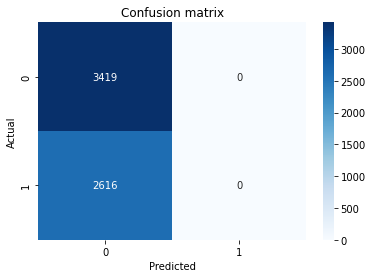

In [ ]:
print("Accuracy:",accuracy_score(y_test,y_pred))

cm = confusion_matrix(y_test,y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap='Blues',fmt="d"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion matrix'); 